# Create datasets from PNG images

<img src="data/resources/main_photo.jpg" alt="Output image" width=300 height=200/>

This project is about create datasets from PNG images for instance segmentation. 

**NOTE:** Using alpha channel as mask we can extract polygon as X, Y coordinates.


## 1.) Load image
Load image and mask as third channel, setup threshold on mask where each number below 127 is zero and 255 otherwise


Image shape: (1351, 1000)


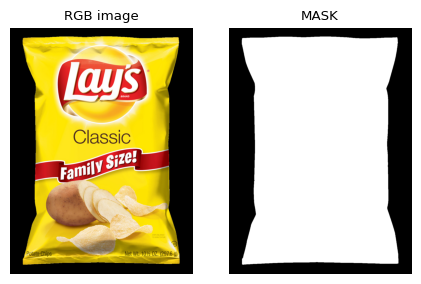

In [18]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = r"data/resources/lays.png" # Image path
image_array = cv2.imread(image_path, -1) # load image with alpha (-1) for load all channels with alpha
image_array_bgr = image_array[:, : , :3] # Load BGR image, default it's BGR
image_array_rgb = cv2.cvtColor(image_array_bgr, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
image_array_mask = image_array[:, :, -1] # Mask from PNG
image_array_mask_thresh = np.where(image_array_mask <= 200, 0, 255).astype(np.uint8) # Setup threshold

# image_array_mask_thresh_blur = cv2.GaussianBlur(image_array_mask_thresh, (5, 5), 0, 0, cv2.BORDER_DEFAULT)

# image_array_mask_blur = cv2.bitwise_and(image_array_mask_thresh, image_array_mask_thresh_blur)

kernel = np.ones((5,5), np.uint8)
eroded_img = cv2.erode(image_array_mask_thresh, kernel, iterations=1)

image_array_rgb = cv2.bitwise_and(image_array_rgb, image_array_rgb, mask=image_array_mask)

plt.figure(figsize=(8, 16))
plt.rcParams.update({'font.size': 8})
plt.subplot(1, 3, 1)
plt.imshow(image_array_rgb)
plt.title("RGB image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(image_array_mask_thresh, cmap="gray")
plt.title("MASK")
plt.axis("off")

print(f"Image shape: {image_array_mask_thresh.shape}")

# cv2.imwrite("example.jpg",np.hstack((image_array_mask_thresh, eroded_img)))

## 2.) Create polygon
Create polygon from image mask resource [link](https://github.com/hazirbas/coco-json-converter/blob/master/generate_coco_json.py) and draw contour on RGB image


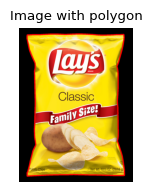

In [19]:
def polygon_from_mask(masked_array):
    """The function return polygon from mask"""
    contours, _ = cv2.findContours(masked_array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    valid_poly = 0
    for c, contour in enumerate(contours):
        if contour.size >= 6: # Valid polygons have >= 6 coordinates (3 points)
            segmentation.append(contour.astype(float).flatten().tolist())
            valid_poly += 1
    if valid_poly == 0:
        raise ValueError
    return segmentation

polygon_list = polygon_from_mask(image_array_mask_thresh) # Get polygon coordinates list [x1,y1,x2,y2]
polygon_array = np.array(polygon_list[0], dtype=np.int32).reshape((-1, 2)) # Reshape to 2D matrix 1st col X 2nd col Y 

pts = polygon_array.reshape((-1, 1, 2)) # Reshape poolygon array to 3rd dimension
image_array_rgb_copy = image_array_rgb.copy() 
cv2.polylines(image_array_rgb_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=10) # Draw polygon

plt.figure(figsize=(2, 2))
plt.imshow(image_array_rgb_copy)
plt.title("Image with polygon")
plt.axis(False)
plt.show()

## 3.) Cut image
Cut MASK with polygon coordinates, calculate new polygon values and draw RGB with new polygon

Image shape: (1247, 855, 3)


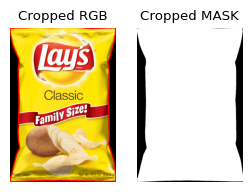

In [20]:
(min_x, min_y), (max_x, max_y) = np.min(polygon_array, axis=0), np.max(polygon_array, axis=0) # Calculate MIN/MAX values for cut 
image_rgb_crop = image_array_rgb[min_y: max_y, min_x: max_x] # Crop RGB image 
image_mask_crop = image_array_mask_thresh[min_y: max_y, min_x: max_x] # Crop MASK

polygon_list_crop = polygon_from_mask(image_mask_crop) # Get polygon coordinates list [x1,y1,x2,y2]
polygon_array_crop = np.array(polygon_list_crop[0], dtype=np.int32).reshape((-1, 2)) # Reshape to 2D matrix 1st col X 2nd col Y 

pts = polygon_array_crop.reshape((-1, 1, 2)) # Reshape poolygon array to 3rd dimension
image_rgb_crop_copy = image_rgb_crop.copy() 
cv2.polylines(image_rgb_crop_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=10) # Draw polygon


plt.figure(figsize=(3, 8))
plt.rcParams.update({'font.size': 8})
plt.subplot(1, 2, 1)
plt.imshow(image_rgb_crop_copy)
plt.title("Cropped RGB")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image_mask_crop, cmap="gray")
plt.title("Cropped MASK")
plt.axis("off")
print(f"Image shape: {image_rgb_crop.shape}")

## 4.) Rotate image
Rotate cropped image with cutom angle and expands image to avoid cropping

Image shape: (1247, 855, 3)


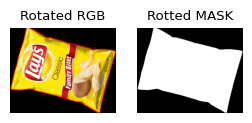

In [21]:
from library.utils import rotate_image

image_rgb_rotate = rotate_image(image_rgb_crop, 75) # Rotate RGB image
image_mask_rotate = rotate_image(image_mask_crop, 75) # Rotate MASK

polygon_list_rotate = polygon_from_mask(image_mask_rotate) # Get polygon coordinates list [x1,y1,x2,y2]
polygon_array_rotate = np.array(polygon_list_rotate[0], dtype=np.int32).reshape((-1, 2)) # Reshape to 2D matrix 1st col X 2nd col Y 

pts = polygon_array_rotate.reshape((-1, 1, 2)) # Reshape poolygon array to 3rd dimension
image_rgb_rotate_copy = image_rgb_rotate.copy() 
cv2.polylines(image_rgb_rotate_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=10) # Draw polygon

plt.figure(figsize=(3, 8))
plt.rcParams.update({'font.size': 8})
plt.subplot(1, 2, 1)
plt.imshow(image_rgb_rotate_copy)
plt.title("Rotated RGB")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image_mask_rotate, cmap="gray")
plt.title("Rotted MASK")
plt.axis("off")
print(f"Image shape: {image_rgb_crop.shape}")

## 5.) Place image
Place the image on top of the other [link](https://stackoverflow.com/questions/35783062/opencv-python-copy-polygon-from-one-image-to-another)
**NOTE:** For demonstration purposes

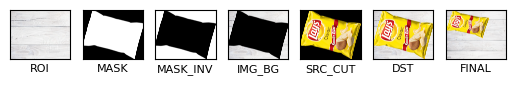

In [22]:
background_array = cv2.imread('data/resources/table.jpg') # Load background image
background_array = cv2.resize(background_array, (2000, 2000), interpolation=cv2.INTER_AREA) # Resize image (width, height)

(min_x, min_y), (max_x, max_y) = np.min(polygon_array_rotate, axis=0), np.max(polygon_array_rotate, axis=0) # Calculate MIN/MAX values for cut 
roi = background_array[min_y: max_y, min_x: max_x] # Cut ROI from background (Coordinates for CUT)
mask = image_mask_rotate[min_y: max_y, min_x: max_x] # Caut MASK same as ROI from image mask

mask_inv = cv2.bitwise_not(mask) # Invert mask
img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv) # 
src_cut = image_rgb_rotate[min_y: max_y, min_x: max_x]

dst = cv2.add(img_bg, src_cut)
final = background_array.copy()
final[min_y: max_y, min_x: max_x] = dst

fig, axs = plt.subplots(nrows=1, ncols=7, sharex=True, sharey=True)
axs[0].imshow(roi)
axs[0].set_xlabel("ROI")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(mask, cmap="gray")
axs[1].set_xlabel("MASK")
axs[2].imshow(mask_inv, cmap="gray")
axs[2].set_xlabel("MASK_INV") 
axs[3].imshow(img_bg, cmap="gray")
axs[3].set_xlabel("IMG_BG") 
axs[4].imshow(src_cut, cmap="gray")
axs[4].set_xlabel("SRC_CUT")
axs[5].imshow(dst, cmap="gray")
axs[5].set_xlabel("DST")
axs[6].imshow(cv2.resize(final, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_AREA))
axs[6].set_xlabel("FINAL")
plt.show()

## 6.) Random place + overlay objects
Place image random on background
Create random black background, place image, calculate polygon.

<img src="resources/example_mask.png" alt="Output image" width=300 heigh=200/>



Image shape: (1148, 1425)


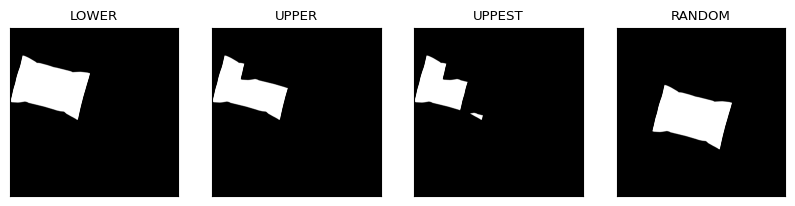

In [16]:
from random import randint
from library.utils import place_object


black_background = np.zeros((3000, 3000), dtype=np.uint8)

first_object = place_object(polygon=polygon_array_rotate, 
                            background=black_background, 
                            image_mask=image_mask_rotate, 
                            image=image_mask_rotate, 
                            off_x=0, off_y=500)

second_object = place_object(polygon=polygon_array_rotate, 
                            background=first_object, 
                            image_mask=image_mask_rotate, 
                            image=image_mask_rotate, 
                            off_x=500, off_y=100, inv=True)

third_object = place_object(polygon=polygon_array_rotate, 
                            background=second_object, 
                            image_mask=image_mask_rotate, 
                            image=image_mask_rotate, 
                            off_x=800, off_y=700, inv=True)


fourth_object = place_object(polygon=polygon_array_rotate, 
                            background=black_background, 
                            image_mask=image_mask_rotate, 
                            image=image_mask_rotate, 
                            off_x=randint(0, 3000-image_mask_rotate.shape[1]), 
                            off_y=randint(0, 3000-image_mask_rotate.shape[0]))

plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 8, 'ytick.left': False,
                     'xtick.labelbottom': False, 'xtick.bottom': False,
                     'ytick.labelleft': False})
plt.subplot(1, 4, 1)
plt.imshow(first_object, cmap="gray")
plt.title("LOWER")
plt.subplot(1, 4, 2)
plt.imshow(second_object, cmap="gray")
plt.title("UPPER")
plt.subplot(1, 4, 3)
plt.imshow(third_object, cmap="gray")
plt.title("UPPEST")
plt.subplot(1, 4, 4)
plt.imshow(fourth_object, cmap="gray")
plt.title("RANDOM")
print(f"Image shape: {image_mask_rotate.shape}")

In [17]:
import os
import cv2
import numpy as np
from random import sample, randint

import matplotlib.pyplot as plt

from library.utils import load_image_mask, polygon_from_mask
from library.png_image import load_images

background = (2000, 2000)    
images_path = r"data/icons" # Images path   
background_array = cv2.imread('data/resources/table.jpg')
background_array = cv2.resize(background_array, background, interpolation=cv2.INTER_AREA) 
black_background = np.zeros((background), dtype=np.uint8)

images = load_images(images_path, background, num=10) 


for pos, image in enumerate(images, 0):
    background_array = place_object(polygon=image.polygon, 
                                    background=background_array, 
                                    image_mask=image.mask, 
                                    image=image.rgb, 
                                    off_x=image.off_x, off_y=image.off_y)
    black_background = place_object(polygon=image.polygon, 
                                    background=black_background, 
                                    image_mask=image.mask, 
                                    image=image.mask, 
                                    off_x=image.off_x, off_y=image.off_y, inv=False)
    
    for image in images[pos+1: ]:
        black_background = place_object(polygon=image.polygon, 
                                        background=black_background, 
                                        image_mask=image.mask, 
                                        image=image.mask, 
                                        off_x=image.off_x, off_y=image.off_y, inv=True)
    
    polygon_list = polygon_from_mask(black_background)
    for polygon in polygon_list:
        polygon_array = np.array(polygon, dtype=np.int32).reshape((-1, 2))
        pts = polygon_array.reshape((-1, 1, 2))
        cv2.polylines(background_array, [pts], isClosed=True, color=(randint(0, 255), randint(0, 255), randint(0, 255)), thickness=10) # Draw polygon

    black_background = np.zeros((background), dtype=np.uint8)  
    
plt.figure(figsize=(2, 2))    
plt.imshow(cv2.cvtColor(background_array, cv2.COLOR_BGR2RGB))
plt.axis(False)
black_background.shape


ValueError: Sample larger than population or is negative

## 7.) GRAY & [DepthToNormal](https://stackoverflow.com/questions/53350391/surface-normal-calculation-from-depth-map-in-python)
- Convert RGB to GRAY
- Convert DPT to normal only first & second channel
- Concatenate 1.GRAY & 2.3.NORMAL

<img src="data/resources/example_normal_inv.jpg" alt="Output image" width=200 height=200/>



In [3]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_surface_normal_by_depth(depth, K=None):
    """
    depth: (h, w) of float, the unit of depth is meter
    K: (3, 3) of float, the depth camere's intrinsic
    """
    K = [[1, 0], [0, 1]] if K is None else K
    fx, fy = K[0][0], K[1][1]

    dz_dv, dz_du = np.gradient(depth)  # u, v mean the pixel coordinate in the image
    # u*depth = fx*x + cx --> du/dx = fx / depth
    du_dx = fx / depth  # x is xyz of camera coordinate
    dv_dy = fy / depth

    dz_dx = dz_du * du_dx
    dz_dy = dz_dv * dv_dy
    # cross-product (1,0,dz_dx)X(0,1,dz_dy) = (-dz_dx, -dz_dy, 1)
    normal_cross = np.dstack((-dz_dx, -dz_dy, np.ones_like(depth)))
    
    # normalize to unit vector
    normal_unit = normal_cross / np.linalg.norm(normal_cross, axis=2, keepdims=True)
    # set default normal to [0, 0, 1]
    normal_unit[~np.isfinite(normal_unit).all(2)] = [0, 0, 1]
    return normal_unit

# Paths to images & dpts
path_to_rgb = r"C:\Users\Martin\Desktop\New folder\rgb"
path_to_dpt = r"C:\Users\Martin\Desktop\New folder\dpt"
path_to_gray_normal = r"C:\Users\Martin\Desktop\New folder\gray_normal"

for rgb_name, dpt_name in zip(os.listdir(path_to_rgb), os.listdir(path_to_dpt)):
    assert rgb_name == dpt_name, f"Inconsistent data: {rgb_name} != {dpt_name}"
    bgr_array = cv2.imread(os.path.join(path_to_rgb, rgb_name))
    dpt_array = cv2.imread(os.path.join(path_to_dpt, dpt_name))

    gray_array = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2GRAY)
    gray_array = np.expand_dims(gray_array, axis=-1)

    dpt_array = cv2.cvtColor(dpt_array, cv2.COLOR_BGR2GRAY)
    dpt_array = np.where(dpt_array == 0, 1, dpt_array)

    vis_normal = lambda normal: np.uint8((normal + 1) / 2 * 255)
    normal = get_surface_normal_by_depth(dpt_array, K=None) 
    vis_normal = vis_normal(normal)

    gray_normal = np.concatenate((gray_array, vis_normal[:, :, :2]), axis=-1)

    cv2.imwrite(os.path.join(path_to_gray_normal, rgb_name), gray_normal)

## 8.) Hole filling

<img src="data/resources/bannanas_mask.jpg" alt="Output image" width=500 height=300/>



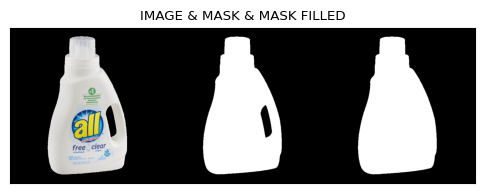

In [128]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = r"data\test\sasasas.png" # Image path
image_array = cv2.imread(image_path, -1) # load image with alpha (-1) for load all channels with alpha
image_array_bgr = image_array[:, : , :3] # Load BGR image, default it's BGR
image_array_rgb = cv2.cvtColor(image_array_bgr, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
image_array_mask = image_array[:, :, -1] # Mask from PNG
image_array_mask_thresh = np.where(image_array_mask <= 127, 0, 255).astype(np.uint8) # Setup threshold

image_array_rgb = cv2.bitwise_and(image_array_rgb, image_array_rgb, mask=image_array_mask)

fill_mask = np.copy(image_array_mask_thresh)
contours, _ = cv2.findContours(image_array_mask_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours[1:]: 
    cv2.fillPoly(fill_mask, pts=[contour], color =(255, 255, 255))

plt.figure(figsize=(6, 12))
plt.imshow(np.hstack((image_array_rgb, cv2.cvtColor(image_array_mask_thresh, cv2.COLOR_GRAY2BGR), cv2.cvtColor(fill_mask, cv2.COLOR_GRAY2BGR))))
plt.title("IMAGE & MASK & MASK FILLED")
plt.show()

## 9.) Train valid split

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to input images and labels
images_path = r"C:\Users\Martin\Desktop\Groceries from PNG-V3\images"
labels_path = r"C:\Users\Martin\Desktop\Groceries from PNG-V3\labels"
out_path = r"C:\Users\Martin\Desktop\Groceries from PNG-V3"

# Remove old directory
shutil.rmtree(out_path + os.sep + "datasets", ignore_errors=True)

# Make directories
paths = [r"datasets\train\images",
         r"datasets\valid\images",
         r"datasets\train\labels",
         r"datasets\valid\labels"]

_ = [os.makedirs(out_path + os.sep +i, exist_ok=True) for i in paths]

# Wite yaml file
with open(os.path.join(out_path, "datasets", "data.yaml"), 'w') as file:
    file.write(
"""train: ../train/images
val: ../valid/images

nc: 1
names: ['object']""")
    
# Split files
X, y = [], []
for img, lbl in zip(os.listdir(images_path), os.listdir(labels_path)):
    assert (img.replace(".jpg", "") == lbl.replace(".txt", ""))
    X.append([img])
    y.append(lbl)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, shuffle=True,)# random_state=42)
_ = [shutil.copy(images_path + os.sep + x[0], out_path + os.sep + paths[0] + os.sep + x[0])  for x in X_train]
_ = [shutil.copy(images_path + os.sep + x[0], out_path + os.sep + paths[1] + os.sep + x[0])  for x in X_valid]
_ = [shutil.copy(labels_path + os.sep + x, out_path + os.sep + paths[2] + os.sep + x)  for x in y_train]
_ = [shutil.copy(labels_path + os.sep + x, out_path + os.sep + paths[3] + os.sep + x)  for x in y_valid]
